## Imports and Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from scipy.spatial.distance import cosine
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cpu


## Dataset Class

In [2]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        elif split == "test":
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]
        else:
            # ground truth images
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)

        # Optional RAM caching
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if self.cache:
        #     img = self.cached_images[idx]
        # else:
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

### Create Datasets

In [3]:
from torch.utils.data import ConcatDataset
import os

MVTEC_ROOT = "./Dataset"
BATCH_SIZE = 40
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

transform = get_transforms(IMAGE_SIZE)

def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")
ground_truth_dataset = build_concat("ground_truth")


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


### Show Dataset Images

TRAINING IMAGES


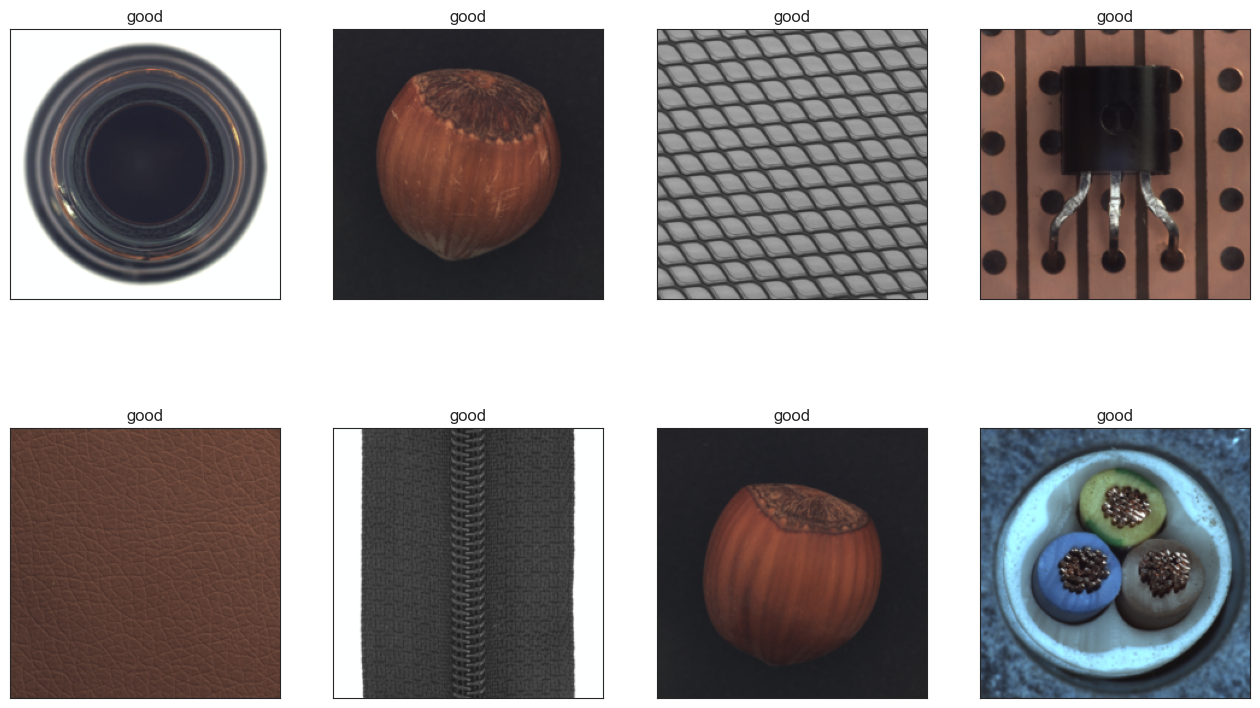

TESTING IMAGES


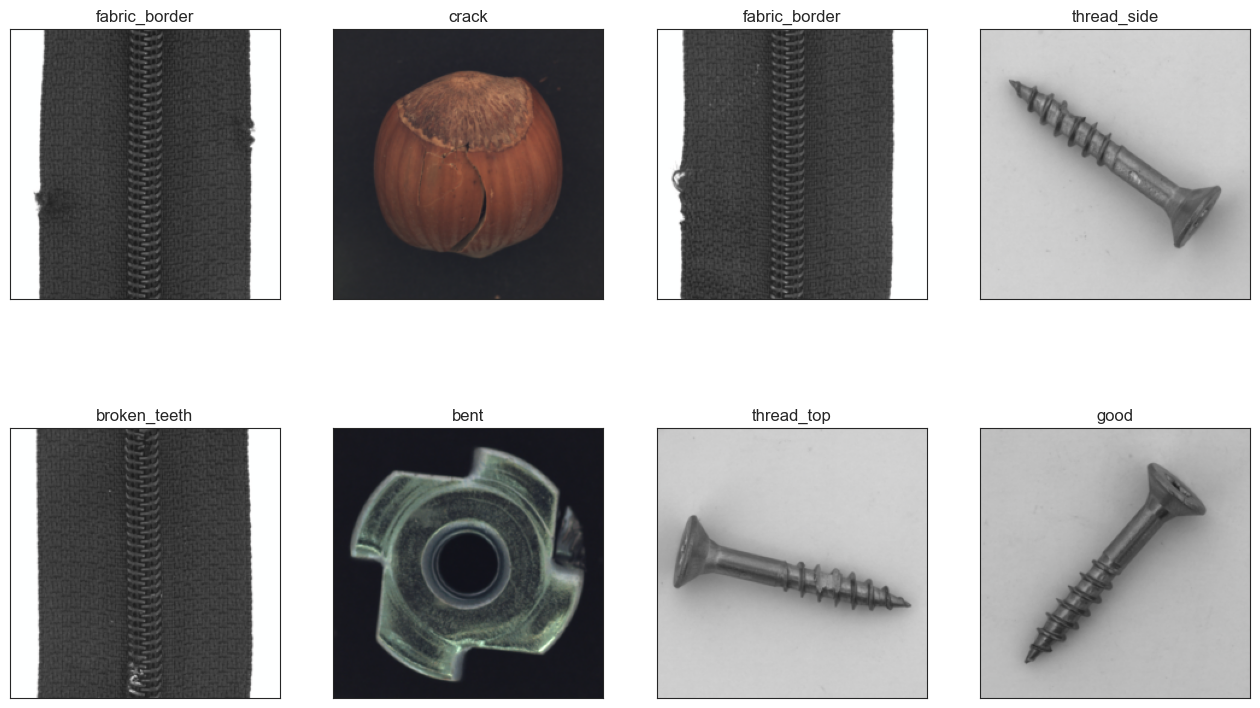

GROUND TRUTH MASKS


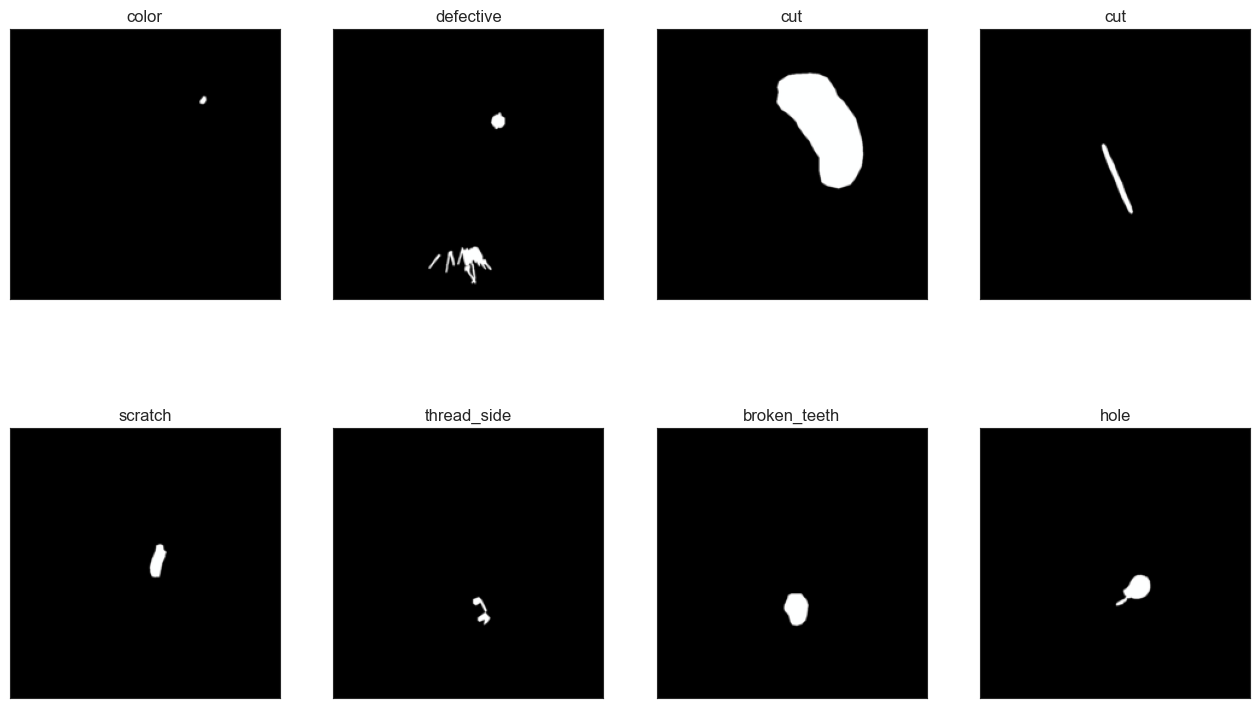

In [4]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]

        plt.sca(ax)
        show_image(img, label)

    plt.show()


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

ground_truth_example_loader = DataLoader(
    dataset=ground_truth_dataset, batch_size=8, shuffle=True
)
print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)
print("GROUND TRUTH MASKS")
show_dataset_examples(ground_truth_example_loader)

## Embed training features using mean pooling

### Constants

In [61]:
EMBEDDING_FILE_EXT = "embeddings.npz"
PATCH_EMBEDDINGS_FOLDER = "./patch_embeddings"
POOLED_EMBEDDINGS_FOLDER = "./pooled_embeddings"
MODEL_URL = "vit_small_patch16_dinov3_qkvb.lvd1689m"

POOLED_TRAIN_PATH = f"{POOLED_EMBEDDINGS_FOLDER}/train_{EMBEDDING_FILE_EXT}"
POOLED_TEST_PATH = f"{POOLED_EMBEDDINGS_FOLDER}/test_{EMBEDDING_FILE_EXT}"
PATCH_TRAIN_PATH = f"{PATCH_EMBEDDINGS_FOLDER}/train_{EMBEDDING_FILE_EXT}"
PATCH_TEST_PATH = f"{PATCH_EMBEDDINGS_FOLDER}/test_{EMBEDDING_FILE_EXT}"

NUM_PATCHES_PER_IMAGE = 196

In [6]:


def save_embeddings_compressed(embeddings, save_path, dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    print(f"Compressed embeddings saved to: {npz_path}")
    print(f"File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path, n_register_tokens=0):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """
    print(f"Loading compressed embeddings from: {npz_path}")

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]
    labels = data["labels"]

    # Remove register tokens from each image when using patch embeddings
    if n_register_tokens > 0:
        emb_arrays = emb_arrays[:, n_register_tokens:, :]

    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]

    print(
        f"Loaded {len(embeddings)} embeddings with shape {emb_arrays.shape[1:]} per image"
    )

    return embeddings

In [7]:
def embed_and_save_features(
    dataloader, split, embedding_folder, model_url=MODEL_URL, device="cuda"
):
    """
    Efficient, stable DINOv3 patch embedding extractor.
    Uses mean pooling over patch tokens → 384-dim embeddings.
    """
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):

            images = images.to(device)

            feats = model.forward_features(images)

            if isinstance(feats, dict):
                x = feats.get("x_norm")  
            else:
                x = feats

            emb = x.mean(dim=1)

            emb = emb.cpu().numpy()

            for i, label in enumerate(labels):
                lbl = label.item() if isinstance(label, torch.Tensor) else label
                embeddings.append((emb[i], lbl))

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx+1} batches")

    save_embeddings_compressed(
        embeddings=embeddings, dataset_name=split, save_path=embedding_folder
    )
    return embeddings

In [8]:
import csv 
def cosine_sim_matrix(test_vec, gt_mat):
    """
    test_vec: (384,)
    gt_mat:   (N, 384)
    returns:  (N,)
    """
    return (gt_mat @ test_vec).ravel() 


def compare_and_draw_conclusion(
    embedding_folder, threshold=0.8,
    rank=10,
    csv_path="results.csv",
):
    train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"

    embeddings_GT = (
        load_embeddings_compressed(train_path)
        if os.path.exists(train_path)
        else embed_and_save_features(train_loader, "train", embedding_folder=embedding_folder)
    )

    embeddings_Test = (
        load_embeddings_compressed(test_path)
        if os.path.exists(test_path)
        else embed_and_save_features(test_loader, "test", embedding_folder=embedding_folder)
    )

    gt_vecs, _ = zip(*embeddings_GT)
    gt_mat = np.asarray(gt_vecs, dtype=np.float32)

    gt_mat /= np.linalg.norm(gt_mat, axis=1, keepdims=True) + 1e-8

    results = []
    correct = 0
    total = 0

    for idx, (test_vec, label) in enumerate(embeddings_Test):

        tv = np.asarray(test_vec, dtype=np.float32)
        tv /= np.linalg.norm(tv) + 1e-8

        sims = cosine_sim_matrix(tv, gt_mat)

        # select rank-th highest similarity
        kth = np.partition(sims, -rank)[-rank] if len(sims) >= rank else sims.max()

        pred = "good" if kth > threshold else "anomalous"
        true = "good" if str(label).lower() == "good" else "anomalous"

        ok = int(pred == true)
        correct += ok
        total += 1

        results.append(
            {
                "Test_Index": total,
                "True_Label": true,
                "Predicted_Label": pred,
                f"{rank}th_Best_Similarity": kth,
                "Correct": ok,
            }
        )

    acc = correct / total if total else 0

    results.append(
        {
            "Test_Index": "TOTAL",
            "True_Label": "",
            "Predicted_Label": "",
            f"{rank}th_Best_Similarity": "",
            "Correct": f"{acc*100:.2f}% ({correct}/{total})",
        }
    )

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Saved: {csv_path}")
    return acc

### This should be replaced with GMM study

In [9]:
# on GPU it takes roughly 3 minutes 18s to process all training and testing embeddings

# compare_and_draw_conclusion(threshold=0.97, rank=25, embedding_folder="./embeddings")

In [10]:
import numpy as np


def load_embeddings_only(path, max_samples=None):
    data = np.load(path, allow_pickle=True)

    if "embeddings" in data:
        X = data["embeddings"]
        y = data.get("labels", None)
    else:
        pairs = data["arr_0"]
        X = np.stack([e for e, _ in pairs])
        y = np.array([l for _, l in pairs])

    if max_samples is not None:
        X = X[:max_samples]
        if y is not None:
            y = y[:max_samples]

    return X, y

## Visualize Mean Pooled Embeddings Using PCA

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def visualize_pca(embeddings, labels=None, title="PCA visualization"):

    embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)

    pca = PCA(n_components=2)
    Xp = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))

    if labels is None:
        plt.scatter(Xp[:, 0], Xp[:, 1], s=8, alpha=0.7)
    else:
        labels = labels.astype(str)
        for lbl in np.unique(labels):
            idx = labels == lbl
            plt.scatter(
                Xp[idx, 0],
                Xp[idx, 1],
                s=10,
                alpha=0.7,
                label=lbl,
            )
        plt.legend()

    var = pca.explained_variance_ratio_ * 100
    plt.xlabel(f"PC1 ({var[0]:.1f}%)")
    plt.ylabel(f"PC2 ({var[1]:.1f}%)")
    plt.title(title)
    plt.grid(True)
    plt.show()

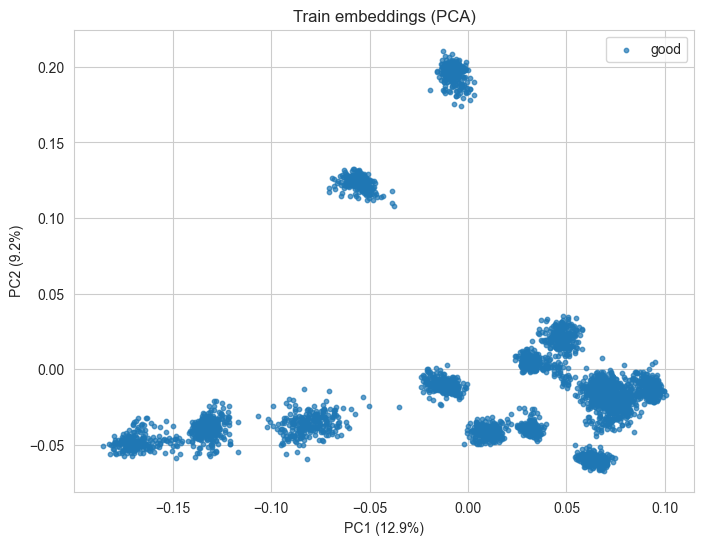

In [15]:
X_test, y_test = load_embeddings_only(
    POOLED_TRAIN_PATH,
)
visualize_pca(X_test, y_test, "Train embeddings (PCA)")

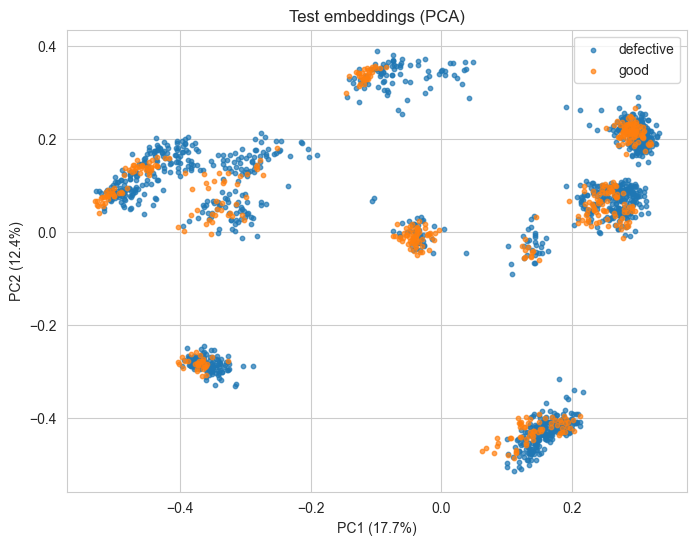

In [16]:
X_test, y_test = load_embeddings_only(
    POOLED_TEST_PATH,
)

y_bin = ["good" if str(label).lower() == "good" else "defective" for label in y_test ]

y_bin = np.array(y_bin)

visualize_pca(X_test, y_bin, "Test embeddings (PCA)")

## Save and Study Patch Embeddings

In [17]:
def extract_patch_embeddings(dataloader, split, model_url=MODEL_URL):
    """
    Extract patch embeddings for all images in a dataloader.
    Returns: patches_embeddings [N_images, N_patches, D], labels [N_images]
    """
    model = timm.create_model(model_url, pretrained=True)
    model.eval().to(device)

    grid_size = model.patch_embed.grid_size
    print(grid_size)

    all_patches = []
    all_labels = []
    i = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Get patch features (no CLS token)
            feats = model.forward_features(images)
            if isinstance(feats, dict):
                patch_feats = feats.get("x_norm")  # shape: [B, N_patches, D]
            else:
                patch_feats = feats[:, 1:, :]  # drop CLS token if exists

            patch_feats = patch_feats.cpu().numpy()
            print("patch shape:", patch_feats.shape)
            all_patches.append(patch_feats)
            all_labels.extend(labels)

            print('loaded batch', i)
            i += 1

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.array(all_labels)

    embeddings = [(patch, label) for patch, label in zip(all_patches, all_labels)]

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split, save_path='./NEW_embeddings')
    return all_patches, all_labels

In [21]:
train_data, train_labels = (
    zip(*load_embeddings_compressed(PATCH_TRAIN_PATH, n_register_tokens=4))
    if os.path.exists(PATCH_TRAIN_PATH)
    else extract_patch_embeddings(train_loader, "train")
)

test_data, test_labels = (
    zip(*load_embeddings_compressed(PATCH_TEST_PATH, n_register_tokens=4))
    if os.path.exists(PATCH_TEST_PATH)
    else extract_patch_embeddings(test_loader, "test")
)

Loading compressed embeddings from: ./patch_embeddings/train_embeddings.npz
Loaded 3629 embeddings with shape (196, 384) per image
Loading compressed embeddings from: ./patch_embeddings/test_embeddings.npz
Loaded 1725 embeddings with shape (196, 384) per image


### Use FAISS to set up memory bank and patch-level knn

In [22]:
import faiss

train_patches = np.stack([np.array(p, dtype=np.float32) for p in train_data])
test_patches = np.stack([np.array(p, dtype=np.float32) for p in test_data])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Flatten train/test patches to 2D arrays
num_train_images, num_patches_per_image, dim = train_patches.shape
num_test_images = test_patches.shape[0]

train_patches_flat = train_patches.reshape(-1, dim)  # (3629*200, 384)
test_patches_flat = test_patches.reshape(-1, dim)  # (1725*200, 384)

print(train_patches_flat.shape, test_patches_flat.shape)


# L2-normalize
faiss.normalize_L2(train_patches_flat)
faiss.normalize_L2(test_patches_flat)

(711284, 384) (338100, 384)


In [ ]:
# use PCA to reduce computation time by reducing dimension of patch embeddings from 384 -> 128

from sklearn.decomposition import PCA

pca_dim = 128
pca = PCA(n_components=pca_dim, whiten=True, svd_solver="randomized")
train_patches_reduced = pca.fit_transform(train_patches_flat)
test_patches_reduced = pca.transform(test_patches_flat)


In [25]:
train_patches_reduced = np.ascontiguousarray(train_patches_reduced, dtype=np.float32)
test_patches_reduced = np.ascontiguousarray(test_patches_reduced, dtype=np.float32)

faiss.normalize_L2(train_patches_reduced)
faiss.normalize_L2(test_patches_reduced)

In [ ]:
dim = train_patches_reduced.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(train_patches_reduced) # memory bank

In [ ]:
def compute_patch_knn(k, index, patches, save_folder, split):
    distances, indices = index.search(patches, k)
    np.savez_compressed(
        f"{save_folder}/{split}_patch_knn.npz",
        distances=distances,
    )
    return distances, indices

### Compute patch-level distances between train vs train patches and test vs train patches

In [54]:
k = 5

train_distance_path = f"{PATCH_EMBEDDINGS_FOLDER}/train_patch_knn.npz"
test_distance_path = f"{PATCH_EMBEDDINGS_FOLDER}/test_patch_knn.npz"

if os.path.exists(train_distance_path):
    train_knn_data = np.load(train_distance_path, allow_pickle=True)
    train_distances = train_knn_data[list(train_knn_data.keys())[0]]
    train_indices = train_knn_data[list(train_knn_data.keys())[1]]

else:
    train_distances, train_indices = compute_patch_knn(
        k=k,
        index=index,
        save_folder=PATCH_EMBEDDINGS_FOLDER,
        patches=train_patches_reduced,
        split="train",
    )
# Remove self-match
train_distances = train_distances[:, 1:]
train_indices = train_indices[:, 1:]

if os.path.exists(test_distance_path):
    test_knn_data = np.load(test_distance_path, allow_pickle=True)
    test_distances = test_knn_data[list(test_knn_data.keys())[0]]
    test_indices = test_knn_data[list(test_knn_data.keys())[1]]
else:
    compute_patch_knn(
        k=k,
        index=index,
        save_folder=PATCH_EMBEDDINGS_FOLDER,
        patches=test_patches_reduced,
        split="test",
    )

In [55]:
test_patch_scores = test_distances.mean(axis=1)
train_patch_scores = train_distances.mean(axis=1)

### Visualize heatmaps

In [64]:
h = w = int(NUM_PATCHES_PER_IMAGE ** (1/2))

test_map = test_patch_scores.reshape(num_test_images, h, w)
train_map = train_patch_scores.reshape(num_train_images, h, w)

### Compare anomalous heatmap with ground truth pixel mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


(-0.5, 223.5, 223.5, -0.5)

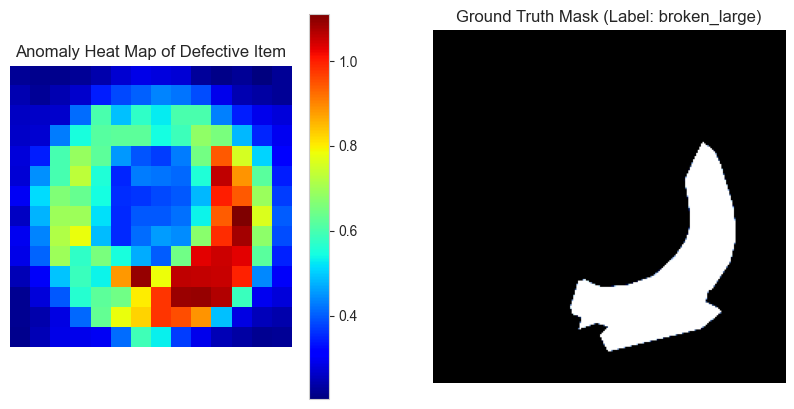

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im = axes[0].imshow(test_map[0], cmap="jet")
axes[0].set_title("Anomaly Heat Map of Defective Item")
fig.colorbar(im, ax=axes[0])
axes[0].axis("off")

img, label = ground_truth_example_loader.dataset[0]
img = img.permute(1, 2, 0).cpu().numpy()
axes[1].imshow(img)
axes[1].set_title(f"Ground Truth Mask (Label: {label})")
axes[1].axis("off")

### Compare heatmap of anomalous image with good image of the same category

(-0.5, 13.5, 13.5, -0.5)

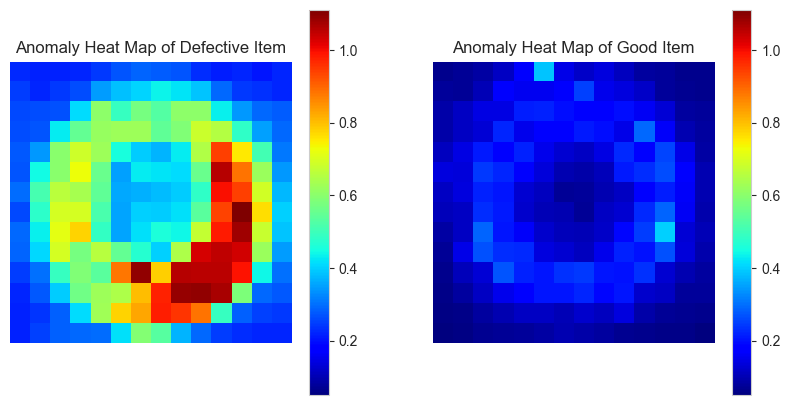

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

anomalous_image_test = test_map[0]
train_image_test = train_map[0]

vmin = min(anomalous_image_test.min(), train_image_test.min())
vmax = max(anomalous_image_test.max(), train_image_test.max())

im_defective = axes[0].imshow(anomalous_image_test, cmap="jet", vmin=vmin, vmax=vmax)
axes[0].set_title("Anomaly Heat Map of Defective Item")
fig.colorbar(im_defective, ax=axes[0])
axes[0].axis("off")

im_good = axes[1].imshow(train_image_test, cmap="jet", vmin=vmin, vmax=vmax)
axes[1].set_title("Anomaly Heat Map of Good Item")
fig.colorbar(im_good, ax=axes[1])
axes[1].axis("off")

In [ ]:
test_image_scores_max = test_map.max(axis=(1, 2))  # max over all patches per image
test_image_scores_mean = test_map.mean(axis=(1, 2))  # mean over all patches per image
print(test_image_scores_max)

[1.1107     1.0043377  1.1485412  ... 0.588246   0.78442645 0.81220436]


In [68]:
train_image_scores_max = train_map.max(axis=(1, 2))
train_image_scores_mean = train_map.mean(axis=(1, 2))
print(train_image_scores_max)

[0.39901772 0.3528969  0.34588113 ... 0.43306088 0.31742382 0.25721404]


## Patch level optuna study for kNN percentile threshold

In [69]:
import optuna
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

def objective(trial):
    # Suggest percentile threshold
    percentile = trial.suggest_int("percentile", 65, 99)

    # Compute threshold from train scores
    threshold = np.percentile(train_image_scores_max, percentile)

    # Compute predicted labels
    pred_labels = (test_image_scores_max > threshold).astype(int)

    true_labels = np.array(
        [0 if label == "good" else 1 for label in test_labels], dtype=int
    )

    # Choose a metric to maximize
    # Example: F1 score
    f1 = f1_score(true_labels, pred_labels)

    # For AUROC, use:
    auroc = roc_auc_score(true_labels, test_image_scores_max)
    return auroc

    # return f1

In [71]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best percentile:", study.best_params["percentile"])
print("Best F1 score:", study.best_value)

[I 2025-12-02 21:46:31,064] A new study created in memory with name: no-name-e6493d84-d05b-4cec-90c7-b9cfaa3b135a
[I 2025-12-02 21:46:31,073] Trial 0 finished with value: 0.8476916896743072 and parameters: {'percentile': 69}. Best is trial 0 with value: 0.8476916896743072.
[I 2025-12-02 21:46:31,082] Trial 1 finished with value: 0.8476916896743072 and parameters: {'percentile': 75}. Best is trial 0 with value: 0.8476916896743072.
[I 2025-12-02 21:46:31,091] Trial 2 finished with value: 0.8476916896743072 and parameters: {'percentile': 95}. Best is trial 0 with value: 0.8476916896743072.
[I 2025-12-02 21:46:31,100] Trial 3 finished with value: 0.8476916896743072 and parameters: {'percentile': 94}. Best is trial 0 with value: 0.8476916896743072.
[I 2025-12-02 21:46:31,105] Trial 4 finished with value: 0.8476916896743072 and parameters: {'percentile': 93}. Best is trial 0 with value: 0.8476916896743072.
[I 2025-12-02 21:46:31,114] Trial 5 finished with value: 0.8476916896743072 and parame

Best percentile: 69
Best F1 score: 0.8476916896743072
